In [1]:
#plotting
import matplotlib.pyplot as plt
%matplotlib notebook
#calculations
import math
import numpy as np
import math
from scipy.signal import savgol_filter
#saving obtained results
import pickle

In [2]:
%load_ext cython

# Pollard $\rho$ algorithm

A prime factorization algorithm also known as Pollard Monte Carlo factorization method. There are two aspects to the Pollard rho factorization method. The first is the idea of iterating a formula until it falls into a cycle. Let $n=pq$, where $n$ is the number to be factored and $p$ and $q$ are its unknown prime factors. Iterating the formula
\begin{align}
    x_{(n+1)}=x_n^2+a (\bmod{n})
\end{align}
or almost any polynomial formula (an exception being $x_n^2-2$) for any initial value $x_0$ will produce a sequence of number that eventually fall into a cycle. The expected time until the $x_ns$ become cyclic and the expected length of the cycle are both proportional to $\sqrt{n}$.

However, since $n=pq$ with $p$ and $q$ relatively prime, the Chinese remainder theorem guarantees that each value of x (mod n) corresponds uniquely to the pair of values (x (mod p)), x (mod q)). Furthermore, the sequence of x_ns follows exactly the same formula modulo p and q, i.e.,

\begin{align}
    x_{(n+1)}	&= [x_n (mod p)]^2+a (\bmod{p}) \\
    x_{(n+1)}	&= [x_n (mod q)]^2+a (\bmod{q})
\end{align}

Therefore, the sequence $(\bmod(p))$ will fall into a much shorter cycle of length on the order of $\sqrt{p}$. It can be directly verified that two values $x_1$ and $x_2$ have the same value $(\bmod{p})$, by computing

\begin{align}
    GCD(\left|x_2-x_1\right|,n), \text{   which is equal to p.}
\end{align}

The second part of Pollard's method concerns detection of the fact that a sequence has become periodic. Pollard's suggestion was to use the idea attributed to Floyd of comparing $x_i$ to $x_{2i}$ for all $i$. A different method is used in Brent's factorization method.

Under worst conditions, the Pollard rho algorithm can be very slow.

(From http://mathworld.wolfram.com/PollardRhoFactorizationMethod.html)

# Algorithm definition

#### Notes: I'm using cython to compile python code into C to make it faster. Also, I'm using GMP (GNU multiprecise library) to speed up calculations.

In [3]:
%%cython
    
from libc.stdint cimport  uint64_t
import gmpy2

def f1(x, n, a):
    return (x * x + a) % n
def f2(x, n, a):
    return (x * x * x + a) % n

def pollard_floyd(n, x1, x2, f, a):
    factor = gmpy2.mpz(1)
    cdef uint64_t it = 0
    while factor == 1:
        x1 = f(x1, n, a)
        x2 = f(f(x2, n, a), n, a)
        factor = gmpy2.gcd(abs(x1 - x2), n)
        it += 1
    if factor == n:
        return None
    else:
        return it

# Experiment description

The purpose is of the first part of experiment to compare real number of iterations of pollard $\rho$ algorithm with theoretic one, using different functions. Currently I'm using two functions:
\begin{align}
    f_1(x) &= x^2 + a (\bmod{n}) \\
    f_2(x) &= x^3 + a (\bmod{n})
\end{align}
With $a\in\{1, 2, 3, 17\}$. Numbers tested are $\in\{2^{20}, ..., 2^{80}\}$ with 2 prime factors which are close to each other.

In second part I'm exploring distribution of number of iteration for fixed number with variable $a$.

# 1) Pollard $\rho$ theoretical estimation and practical results

### Generate random primes

In [4]:
import gmpy2
from random import randint
from itertools import chain

In [5]:
#Number length in binary representation
len_from = 10
len_to = 40
#Number of primes of given length
pr_num = 10

In [6]:
%%time
primes = np.empty([len_to - len_from, pr_num], dtype=object)
for pr_len in range(len_from, len_to):
    for pr_count in range(pr_num):
        num = gmpy2.mpz(randint(2**pr_len, 2**(pr_len + 1)))
        num = gmpy2.next_prime(num)
        primes[pr_len - len_from][pr_count] = num
    primes[pr_len - len_from] = sorted(primes[pr_len - len_from])
primes = list(chain.from_iterable(primes))

CPU times: user 10.2 ms, sys: 211 µs, total: 10.4 ms
Wall time: 11 ms


### Calculate number of cycles

In [12]:
%%time
a_pool = [1, 2, 3, 17]
f_pool = [f1, f2]
res = []
for a in a_pool:
    resfa = []
    for f in f_pool:
        print("Calculating for f=", 'x**' + str('2' if f == f_pool[0] else '3') + '+' + str(a))
        resf = []
        # Calculate for half values if f = x**3 + a
        for i in range(len(primes) - 5 - (((len_to - len_from) // 2 * pr_num) if f == f2 else 0)):
            if i % 10 == 0:
                print(i, end=' ')
            # measuring number of iteration of 2 factors where minimum factor is primes[i]
            resf.append((primes[i], pollard_floyd(
                primes[i] * primes[i + randint(1, 5)], gmpy2.mpz(2), gmpy2.mpz(2), f, gmpy2.mpz(a)
            )))
        resfa.append(resf)
    res.append(resfa)

Calculating for f= x**2+1
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 Calculating for f= x**3+1
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 Calculating for f= x**2+2
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 Calculating for f= x**3+2
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 Calculating for f= x**2+3
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 Calculating for f= x**3+3
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 Calculating for f= x**2+17
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 Calculating for f= x**3+17
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 CPU times: user 3min 33s, sys: 320 ms, total: 3min 33s
Wall time: 3min 33s


In [14]:
with open('res_backup1', 'wb') as f:
    pickle.dump(res, f)

with open('res_backup' 'rb') as f:
    res = pickle.load(f)

## Visualize results

#### Expected number of iteration by Floyd heuristic

In [16]:
#expected number of iterations
expected_x = [x[0] for x in res[0][0]]
expected_y = [math.log(2) * math.sqrt(x[0]) for x in res[0][0]]

### Number of unsuccessful attempts

<IPython.core.display.Javascript object>


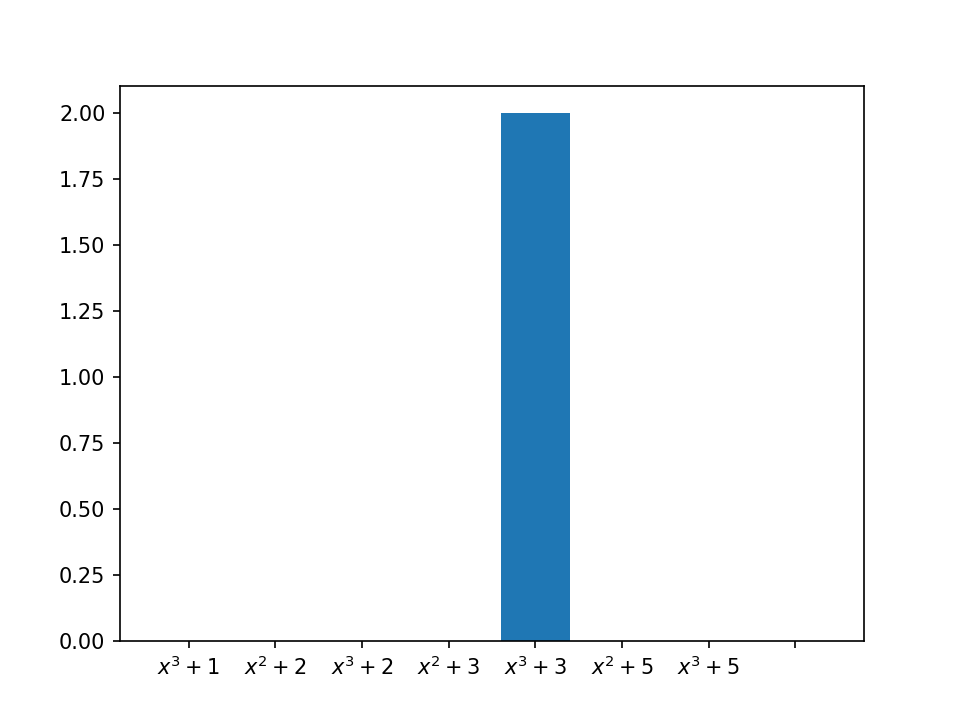

In [38]:
fig = plt.figure(1)
labels = ['$x^2 + 1$', '$x^3 + 1$',
          '$x^2 + 2$', '$x^3 + 2$',
          '$x^2 + 3$', '$x^3 + 3$',
          '$x^2 + 5$', '$x^3 + 5$',
         ]
uns = []
for i in range(len(a_pool)):
    for j in range(len(f_pool)):
        uns.append(len([x for x in res[i][j] if not x[1]]))
ax = fig.add_subplot(111)
ax.bar(range(len(uns)), uns)
ax.set_xticklabels(labels)
plt.show()

### Performance for $f_1$

<IPython.core.display.Javascript object>


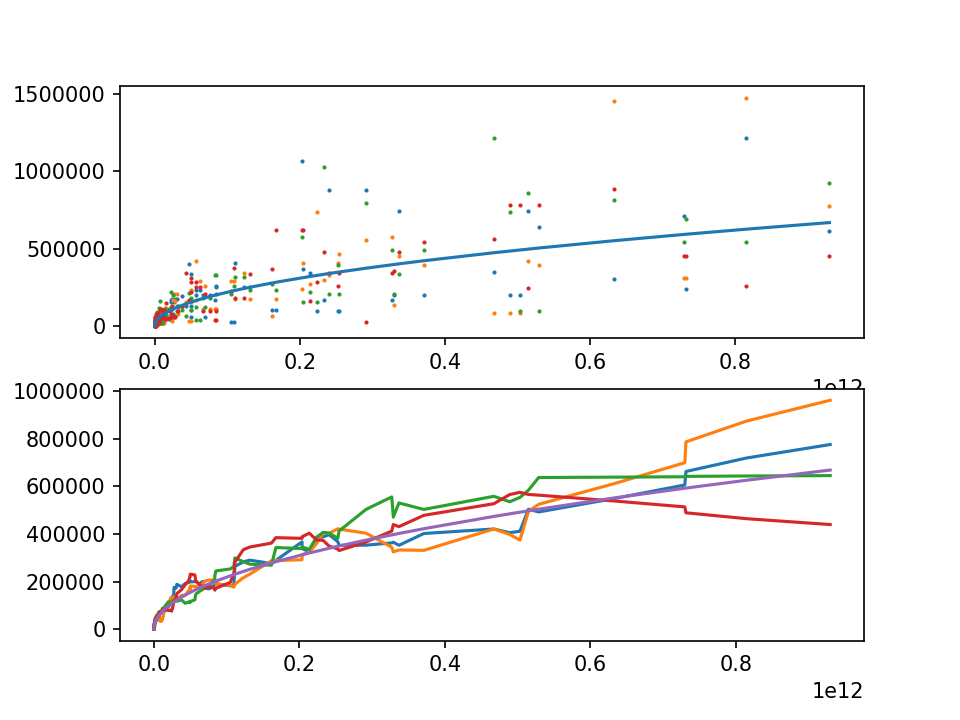

In [41]:
plt.figure(2)
plt.subplot(211)
for i in range(len(a_pool)):
    plt.scatter([x[0] for x in res[i][0]], [x[1] for x in res[i][0]], s=1)savgol_filter([x[1] for x in res[i][0]], pr_num + 1, 1)
plt.plot(expected_x, expected_y)
#smoothed with Savitzky–Golay filter
plt.subplot(212)
for i in range(len(a_pool)):
    plt.plot([x[0] for x in res[i][0]], )
plt.plot(expected_x, expected_y)
plt.show()

### Performance for $f_2$

<IPython.core.display.Javascript object>


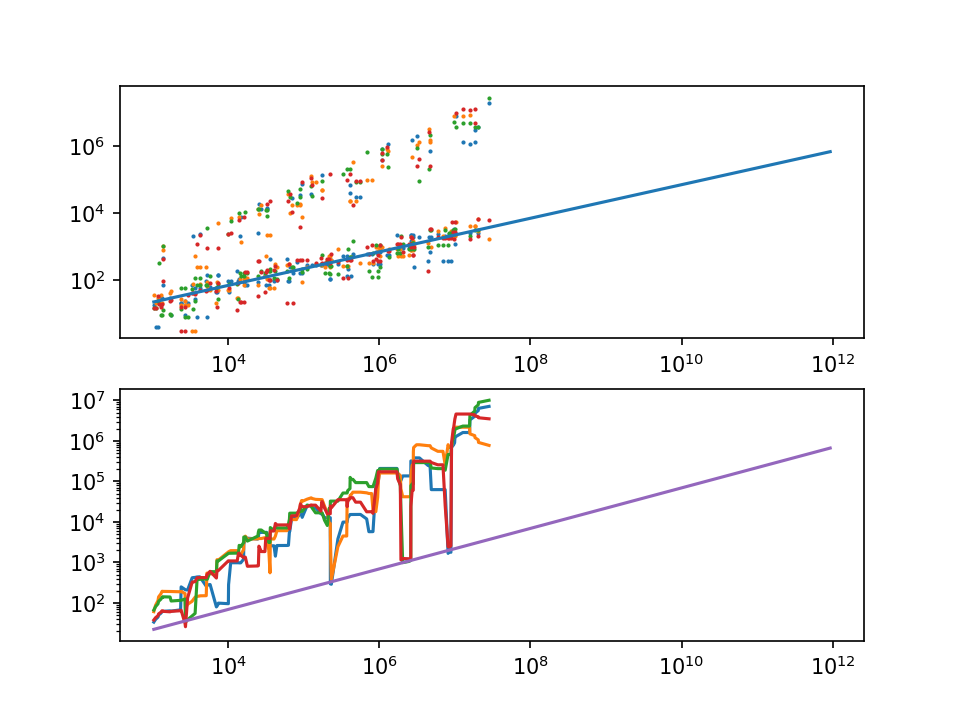

In [42]:
plt.figure(3)
plt.subplot(211)
for i in range(len(a_pool)):
    plt.scatter([x[0] for x in res[i][1]], [x[1] for x in res[i][1]], s=1)
plt.plot(expected_x, expected_y)
plt.xscale('log')
plt.yscale('log')
#smoothed with Savitzky–Golay filter
plt.subplot(212)
for i in range(len(a_pool)):
    plt.plot([x[0] for x in res[i][1]], savgol_filter([x[1] for x in res[i][1]], pr_num + 1, 1))
plt.plot(expected_x, expected_y)
plt.xscale('log')
plt.yscale('log')
plt.show()

### $f_1$ vs $f_2$ with a = 1

<IPython.core.display.Javascript object>


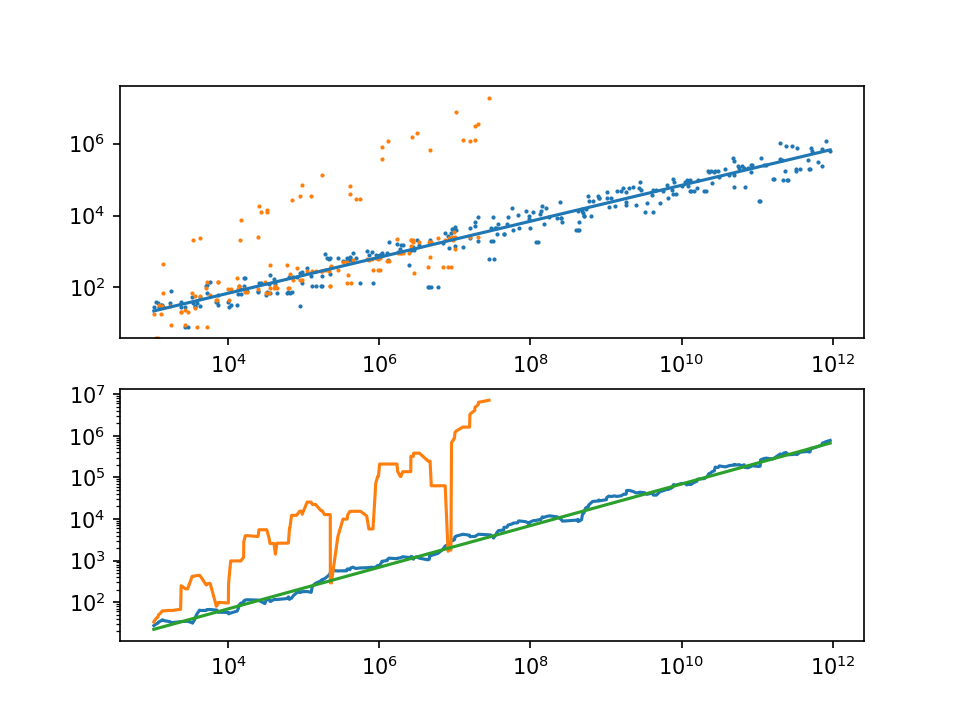

In [44]:
plt.figure(4)
plt.subplot(211)
plt.scatter([x[0] for x in res[0][0]], [x[1] for x in res[0][0]], s=1)
plt.scatter([x[0] for x in res[0][1]], [x[1] for x in res[0][1]], s=1)
plt.xscale('log')
plt.yscale('log')
plt.plot(expected_x, expected_y)
#smoothed with Savitzky–Golay filter
plt.subplot(212)
plt.plot([x[0] for x in res[0][0]], savgol_filter([x[1] for x in res[0][0]], pr_num + 1, 1))
plt.plot([x[0] for x in res[0][1]], savgol_filter([x[1] for x in res[0][1]], pr_num + 1, 1))
plt.xscale('log')
plt.yscale('log')
plt.plot(expected_x, expected_y)
plt.show()


# 2) Distribution of number of iterations with with variable $a$

In [48]:
a_dist = []
for i, a in enumerate([randint(1, primes[-2]) for i in range(1000)]):
    if i % 10 == 0:
        print(i, end = ' ')
    a_dist.append(pollard_floyd(
        primes[-1] * primes[-2], gmpy2.mpz(2), gmpy2.mpz(2), f1, gmpy2.mpz(a)
    ))
a_dist

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 

[1116952,
 160173,
 379405,
 686705,
 638114,
 568485,
 613504,
 1014004,
 1451679,
 1208524,
 1300663,
 313938,
 1179084,
 369655,
 191586,
 1019692,
 1296215,
 363286,
 955470,
 476877,
 751304,
 453220,
 572018,
 453370,
 229081,
 1226388,
 473712,
 1219815,
 354441,
 645022,
 1038657,
 264474,
 612588,
 313565,
 766891,
 997053,
 151629,
 200514,
 537406,
 803559,
 679104,
 1242470,
 389205,
 831034,
 1327428,
 164638,
 1325882,
 979281,
 1167018,
 352542,
 735330,
 1821621,
 791408,
 1307861,
 1066592,
 640140,
 502150,
 955662,
 671202,
 245095,
 344475,
 670576,
 608878,
 1804682,
 474211,
 972015,
 741032,
 1366549,
 183008,
 911480,
 182249,
 499427,
 341538,
 176044,
 732204,
 1145692,
 513744,
 463344,
 885903,
 168172,
 1381904,
 1156143,
 592532,
 1129632,
 1179978,
 625224,
 647820,
 705763,
 237906,
 1612290,
 452396,
 865773,
 416544,
 551973,
 260015,
 1089797,
 190017,
 467712,
 1206273,
 943559,
 1646212,
 536114,
 1137990,
 629888,
 731551,
 591857,
 1565005,
 82486

<IPython.core.display.Javascript object>


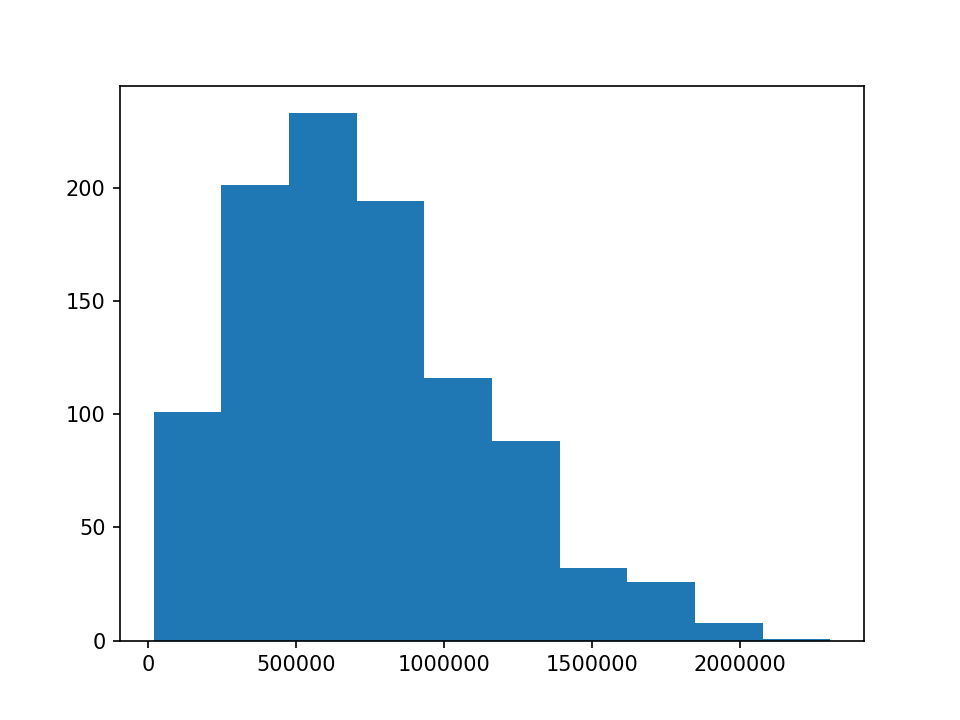

In [50]:
plt.figure(5)
plt.subplot(111)
plt.hist(a_dist)
plt.show()

# Conclusions

For numbers tested and with function $f(x) = x^2 + a (\bmod{n})$ number of iterations in Pollard $\rho$ algorithm is close to theoretical one. Also, there are no big difference which value of a to choose, deviations of number of iterations too small to take it into account.

As for $f(x) = x^3 + a (\bmod{n})$ it is order of magnitude slower than $f(x) = x^2 + a (\bmod{n})$ for all values of a tested.